# NETSI Special Topic: Causal Analysis
## Jupyter notebook on Fisher's exact inference

In this notebook, we are going to perform Fisher's exact inference. With the advancement of computational capacity, Fisher's exact inference is quickly becoming an attractive alternative to Neyman's superpopulation approach. Let's see how it works!

For this exercise, we will use a clinical trial study by van der Leij et al. (2019). The research question of this paper is whether providing hiding box to sheltered cats makes them be less stressed and lose less weight.
* [Article link](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0223492)
* [Data link](https://dataverse.nl/dataset.xhtml?persistentId=hdl:10411/T8LKML)

Assignment mechanism is not exactly specified in the article. Here, we will assume that it is stratified by gender. (Male: 6 treated out of 11; Female: 6 treated out of 12)

In [1]:
## Initial setting
set.seed(15)
library(tidyverse)
library(lfe) # For OLS

## Download data
df <- read.table("https://raw.github.com/DongheeJo/causal-analysis-netsi/master/data/HidingBox/data.txt",
    sep="\t",header=TRUE)

## Sort by gender
df <- df[order(df$gender,df$id),]
rownames(df) <- 1:nrow(df)

## In order to avoid dealing with missing data, let's plug in age = 6 for NA
# (of course in real research you can't do this)
df[8,'age']<-6

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




**1) Let's first calculate Fisher's exact p-value**

In [2]:
## Calculate (quite intiutive) test statistic of choice: weighted average of T_dif for males and females
# Some discussion can be found in Section 9.3 of Imbens and Rubin
df_grp <- df %>% add_count(gender) %>% group_by(gender, treat) %>%
    summarize(stress12 = mean(stress12), weight12 = mean(weight12), count = mean(n)) %>%
    arrange(desc(gender), desc(treat))
# df_grp[1,]: gender 1 treat 1
# df_grp[2,]: gender 1 treat 0
# df_grp[3,]: gender 0 treat 1
# df_grp[4,]: gender 0 treat 0
T_stress <- abs(
    df_grp[1,'count']*(df_grp[1,'stress12']-df_grp[2,'stress12']) +
    df_grp[3,'count']*(df_grp[3,'stress12']-df_grp[4,'stress12'])
    ) %>% pull()
T_weight <- abs(
    df_grp[1,'count']*(df_grp[1,'weight12']-df_grp[2,'weight12']) +
    df_grp[3,'count']*(df_grp[3,'weight12']-df_grp[4,'weight12'])
    ) %>% pull()

In [3]:
T_stress

[1] 7.503966

In [4]:
T_weight

[1] 35.68112

In [5]:
## For complete test, how many re-randomization do we need?
num_m <- table(df$gender)[["0"]][1]
num_f <- table(df$gender)[["1"]][1]
choose(num_f,6)*choose(num_m,6)

[1] 426888

In [6]:
perm_mat <- function(n, m) {
  indices <- expand.grid(replicate(m, 1:n ,simplify=FALSE))
  invalid_order <- apply(indices, 1, function(x) is.unsorted(x, strictly = TRUE))
  invalid_order_rev <- apply(indices, 1, function(x) is.unsorted(x, strictly = TRUE))
  indices <- indices[!(invalid_order | invalid_order_rev),]
  return(indices)
}

m_indices <- perm_mat(num_m, 6)
f_indices <- num_m + perm_mat(num_f, 6)

treated_indices <- merge(m_indices, f_indices, by=NULL)

In [7]:
dim(treated_indices)

[1] 426888     12

In [8]:
## Instead, let's re-randomize num_sim times and get distribution of T_dif
#num_sim = 10000
n_permute <- dim(treated_indices)[1]

sim_T <- as.data.frame(matrix(0, ncol = 2, nrow = n_permute))

for (s in 1:n_permute) {
    sim_df <- df

    sim_df$treat <- 0
    sim_df$treat[as.integer(treated_indices[s,])] <- 1
    sim_df_grp <- sim_df %>% add_count(gender) %>% group_by(gender, treat) %>%
        summarize(stress12 = mean(stress12), weight12 = mean(weight12), count = mean(n)) %>%
        arrange(desc(gender), desc(treat))
    sim_T$T_stress[s] <- abs(
        sim_df_grp[1,'count']*(sim_df_grp[1,'stress12']-sim_df_grp[2,'stress12']) +
        sim_df_grp[3,'count']*(sim_df_grp[3,'stress12']-sim_df_grp[4,'stress12'])
        ) %>% pull()
    sim_T$T_weight[s] <- abs(
        sim_df_grp[1,'count']*(sim_df_grp[1,'weight12']-sim_df_grp[2,'weight12']) +
        sim_df_grp[3,'count']*(sim_df_grp[3,'weight12']-sim_df_grp[4,'weight12'])
        ) %>% pull()
}

[1] "P-value for stress:  0.00128605161072694"


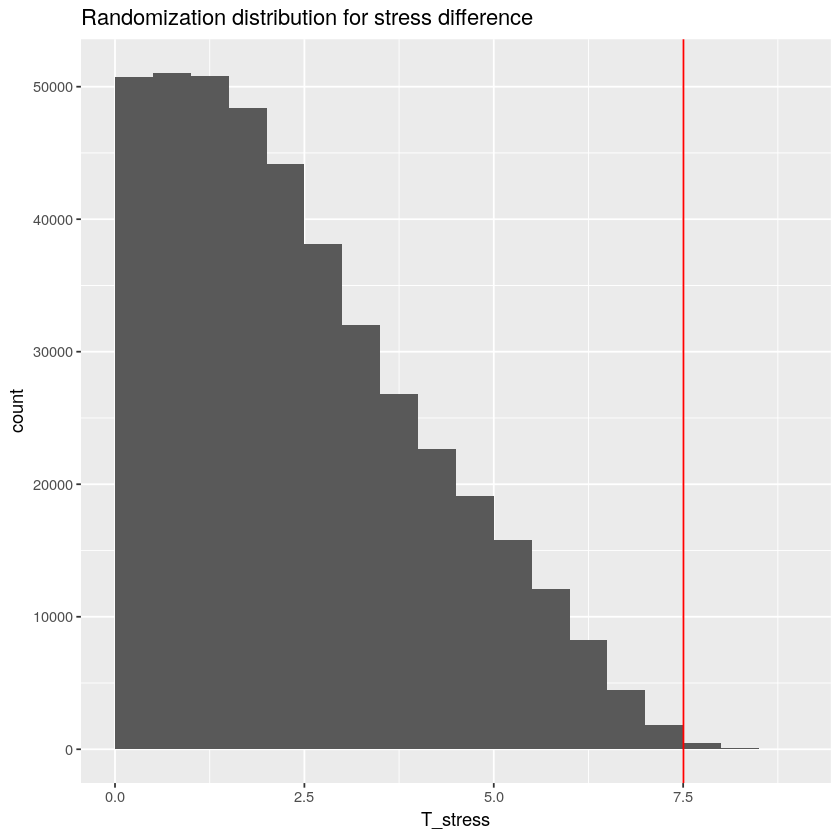

[1] "P-value for weight:  0.414474054084444"


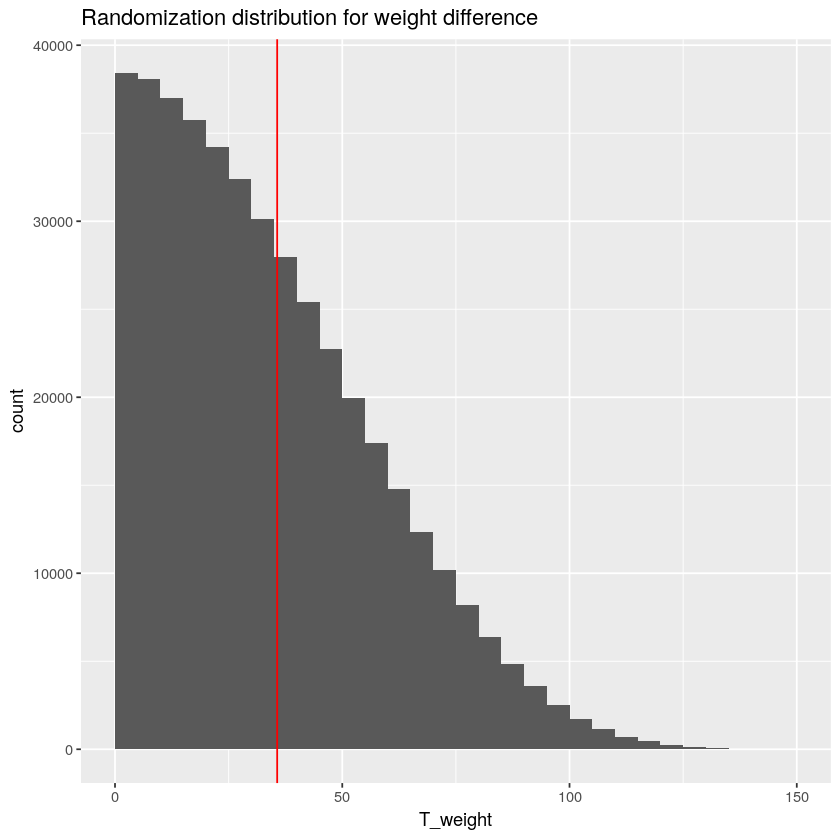

In [9]:
## Draw randomization distribution of our test statistics and calculate p_value.

# 1. Stress
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_stress), boundary=0, binwidth=0.5) +
    geom_vline(xintercept=T_stress, color="red") +
    ggtitle("Randomization distribution for stress difference")
p_stress <- sum(sim_T$T_stress >= T_stress)/n_permute
print(paste("P-value for stress: ",p_stress))

# 2. weight
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_weight), boundary=0, binwidth=5) +
    geom_vline(xintercept=T_weight, color="red") +
    ggtitle("Randomization distribution for weight difference")
p_weight <- sum(sim_T$T_weight >= T_weight)/n_permute
print(paste("P-value for weight: ",p_weight))

**2) How to take into account covariates?**

We can choose regression coefficient (with all the pre-experiment covariates as controls) as our test statistic.

In [10]:
## Instead, let's re-randomize num_sim times and get distribution of T_dif
#num_sim = 10000
n_permute <- dim(treated_indices)[1]

sim_T <- as.data.frame(matrix(0, ncol = 2, nrow = n_permute))


for (s in 1:n_permute) {
    sim_df <- df

    sim_df$treat <- 0
    sim_df$treat[as.integer(treated_indices[s,])] <- 1
    sim_T$T_stress[s] <- coef(summary(felm(stress12 ~ treat + age | gender, data=sim_df)))["treat",1]
    sim_T$T_weight[s] <- coef(summary(felm(weight12 ~ treat + age | gender, data=sim_df)))["treat",1]
}

[1] "P-value for stress:  0.000632484398718165"


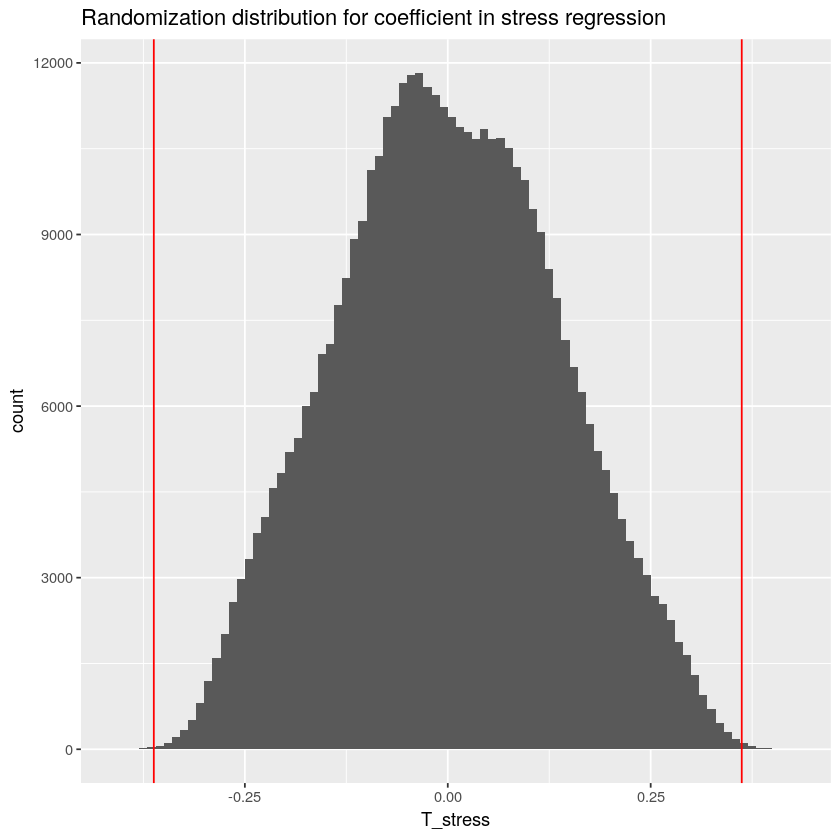

[1] "P-value for weight:  0.212336725323738"


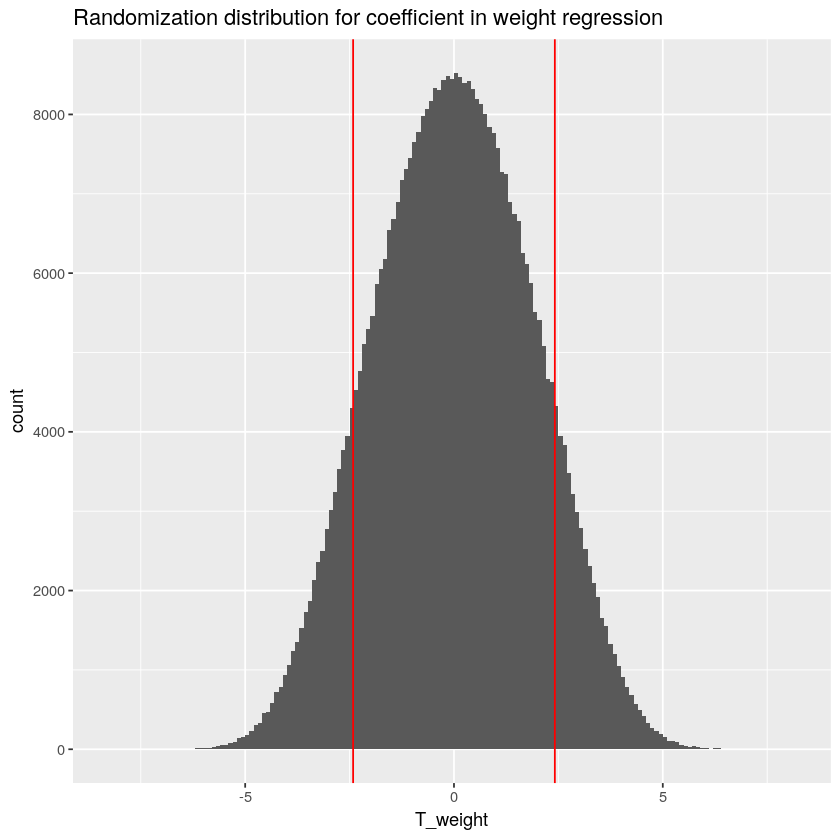

In [11]:
## Draw randomization distribution of our test statistics and calculate p_value.

# 1. Stress
T_stress <- coef(summary(felm(stress12 ~ treat + age | gender, data=df)))["treat",1]
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_stress), boundary=0, binwidth=0.01) +
    geom_vline(xintercept=T_stress, color="red") +
    geom_vline(xintercept=-T_stress, color="red") +
    ggtitle("Randomization distribution for coefficient in stress regression")
p_stress <- sum(abs(sim_T$T_stress) >= abs(T_stress))/n_permute
print(paste("P-value for stress: ",p_stress))

# 2. weight
T_weight <- coef(summary(felm(weight12 ~ treat + age | gender, data=df)))["treat",1]
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_weight), boundary=0, binwidth=0.1) +
    geom_vline(xintercept=T_weight, color="red") +
    geom_vline(xintercept=-T_weight, color="red") +
    ggtitle("Randomization distribution for coefficient in weight regression")
p_weight <- sum(abs(sim_T$T_weight) >= abs(T_weight))/n_permute
print(paste("P-value for weight: ",p_weight))

**3) Constructing confidence interval**

In [12]:
## Stress: what is the minimum/maximum uniform treatment effect C that we stop
#   rejecting the null of tau_i = C for all i at 95% confidence interval?
stress_C <- seq(from=-1,to=0,by=0.025)
weight_C <- seq(from=-3,to=7,by=0.25)
num_sim = 100
cnames <- c()
sim_T <- as.data.frame(matrix(0, ncol = 2*length(stress_C), nrow = num_sim))
for (cnum in 1:length(stress_C)) {
    cnames <- c(cnames,paste("T_stress_s",cnum,sep=""))
    cnames <- c(cnames,paste("T_weight_s",cnum,sep=""))
}
names(sim_T) <- cnames

for (s in 1:num_sim) {
    
    # re-randomize
    a <- sample(1:num_m, 6)
    b <- sample((num_m+1):(num_m+num_f),6)
    df$sim_treat <- 0
    df$sim_treat[c(a,b)] <- 1
    
    for (cnum in 1:length(stress_C)) {
        # calculate imputed value of Y_i[0]
        c_stress <- stress_C[cnum]
        c_weight <- weight_C[cnum]
        df$stress12_s <- df$stress12
        df$weight12_s <- df$weight12
        df[(df$treat==1)&(df$sim_treat==0),"stress12_s"] <- df[(df$treat==1)&(df$sim_treat==0),"stress12"] - c_stress
        df[(df$treat==0)&(df$sim_treat==1),"stress12_s"] <- df[(df$treat==0)&(df$sim_treat==1),"stress12"] + c_stress
        df[(df$treat==1)&(df$sim_treat==0),"weight12_s"] <- df[(df$treat==1)&(df$sim_treat==0),"weight12"] - c_weight
        df[(df$treat==0)&(df$sim_treat==1),"weight12_s"] <- df[(df$treat==0)&(df$sim_treat==1),"weight12"] + c_weight
        # Run regressions
        sim_T[s,paste("T_stress_s",cnum,sep="")] <- coef(summary(felm(stress12_s ~ sim_treat + age | gender, data=df)))["sim_treat",1]
        sim_T[s,paste("T_weight_s",cnum,sep="")] <- coef(summary(felm(weight12_s ~ sim_treat + age | gender, data=df)))["sim_treat",1]
    }
    
    # Monitoring (doesn't work right now; reported after everything is finished)
    if (s%%100 == 0) {
        print(paste("Finished simulation",s))
    }
}

[1] "Finished simulation 100"


In [13]:
## first check whether the p-value for C=0 is similar to what we found above.
# Note that we calculate p-value and confidence interval in the same simulation.
stress_C[41]
weight_C[13]
sum(abs(sim_T$T_stress_s41) >= abs(T_stress))/num_sim
sum(abs(sim_T$T_weight_s13) >= abs(T_weight))/num_sim

[1] 0

[1] 0

[1] 0

[1] 0.28

In [14]:
## Summarize simulated statistics for each C and create confidence interval
pvals <- as.data.frame(matrix(0, ncol = 6, nrow = length(stress_C)))
names(pvals) <- c("C_stress","pval_stress","CI_stress_95","C_weight","pval_weight","CI_weight_95")
for (cnum in 1:length(stress_C)) {
    pvals[cnum,'C_stress'] <- stress_C[cnum]
    pvals[cnum,'pval_stress'] <- sum(abs(sim_T[paste("T_stress_s",cnum,sep="")]-stress_C[cnum]) 
                                     >= abs(T_stress-stress_C[cnum]))/num_sim
    pvals[cnum,'C_weight'] <- weight_C[cnum]
    pvals[cnum,'pval_weight'] <- sum(abs(sim_T[paste("T_weight_s",cnum,sep="")]-weight_C[cnum]) 
                                     >= abs(T_weight-weight_C[cnum]))/num_sim

}
pvals$CI_stress_95 <- (pvals$pval_stress >= 0.05)
pvals$CI_weight_95 <- (pvals$pval_weight >= 0.05)
pvals
# Note: to be conservative, add one more top and bottom.

C_stress,pval_stress,CI_stress_95,C_weight,pval_weight,CI_weight_95
<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>
-1.000,0.00,FALSE,-3.00,0.01,FALSE
-0.975,0.00,FALSE,-2.75,0.02,FALSE
-0.950,0.00,FALSE,-2.50,0.03,FALSE
-0.925,0.00,FALSE,-2.25,0.03,FALSE
-0.900,0.00,FALSE,-2.00,0.04,FALSE
-0.875,0.00,FALSE,-1.75,0.04,FALSE
-0.850,0.00,FALSE,-1.50,0.05,TRUE
-0.825,0.00,FALSE,-1.25,0.06,TRUE
-0.800,0.00,FALSE,-1.00,0.08,TRUE


In [15]:
## Compare with regression confidence interval
st <- felm(stress12 ~ treat + age | gender, data=df)
wt <- felm(weight12 ~ treat + age | gender, data=df)
confint(st, "treat")
confint(wt, "treat")

,2.5 %,97.5 %
treat,-0.6135744,-0.1108078


,2.5 %,97.5 %
treat,-1.638132,6.468515


## Re-doing the analysis (sans CIs) using `ri2`

In [16]:
## Initial setting
set.seed(15)
library(tidyverse)
library(ri2)

## Download data
df <- read.table("https://raw.github.com/DongheeJo/causal-analysis-netsi/master/data/HidingBox/data.txt",
                 sep="\t",header=TRUE)

## Sort by gender
df <- df[order(df$gender,df$id),]
rownames(df) <- 1:nrow(df)

## In order to avoid dealing with missing data, let's plug in age = 6 for NA
# (of course in real research you can't do this)
df[8,'age']<-6

Loading required package: randomizr

Loading required package: estimatr



In [17]:
declaration <- declare_ra(N = dim(df)[1],
                          m = 6,
                          blocks = df$gender)
declaration

Random assignment procedure: Block random assignment 
Number of units: 23 
Number of blocks: 2
Number of treatment arms: 2 
The possible treatment categories are 0 and 1.
The number of possible random assignments is 426888.  
The probabilities of assignment are NOT constant across units. Your analysis strategy must account for differential probabilities of assignment, typically by employing inverse probability weights.

In [18]:
model <- conduct_ri(formula = weight12 ~ treat + age + gender,
                    declaration = declaration,
                    sharp_hypothesis = 0,
                    data = df,
                    assignment = "treat",
                    sims = Inf, # "Inf" means use the full randomization distribution, not samples
                    IPW = TRUE)
model

   term estimate two_tailed_p_value
1 treat 2.425917          0.2111491

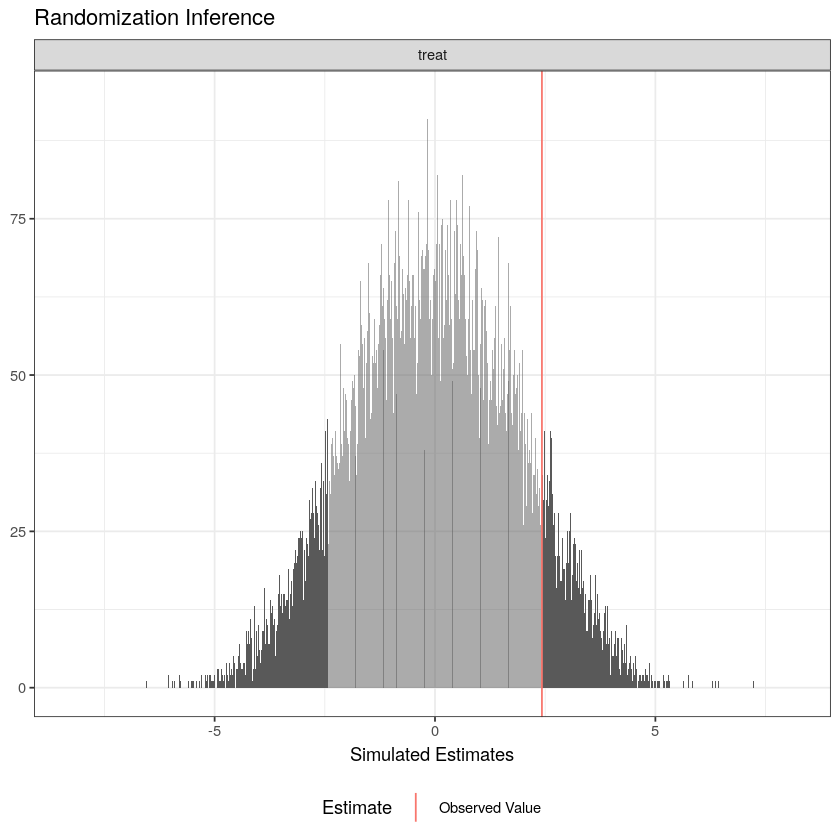

In [19]:
plot(model)

In [20]:
model <- conduct_ri(formula = stress12 ~ treat + age + gender,
                    declaration = declaration,
                    sharp_hypothesis = 0,
                    data = df,
                    assignment = "treat",
                    sims = Inf, # "Inf" means use the full randomization distribution, not samples
                    IPW = TRUE)
model

   term   estimate two_tailed_p_value
1 treat -0.3610461       0.0007285283

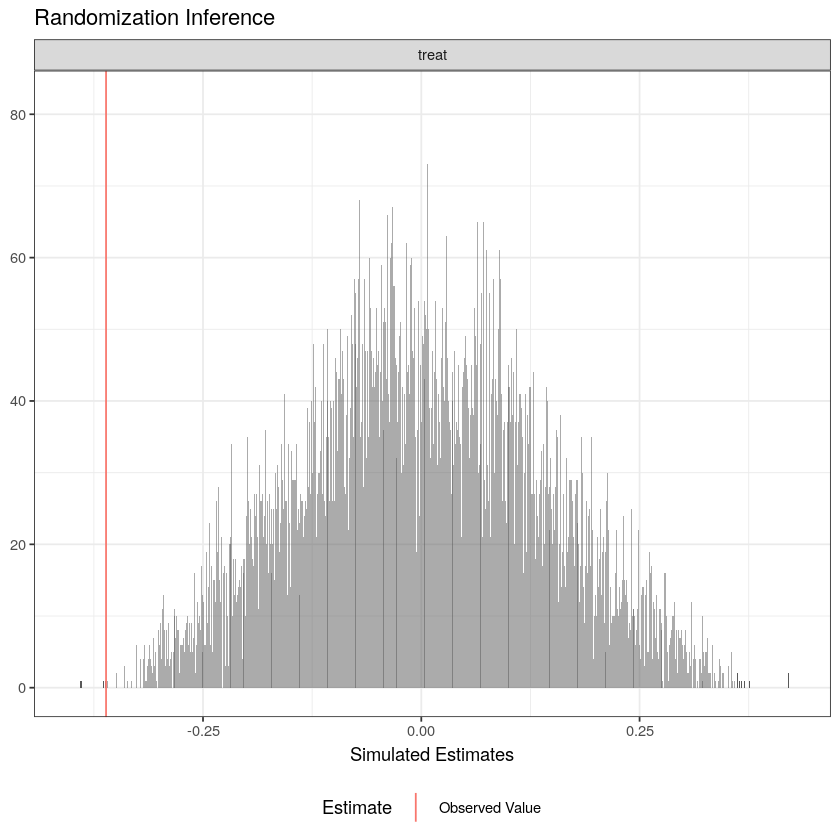

In [21]:
plot(model)